In [ ]:
!pip install tomotopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 37.5 MB/s eta 0:00:00


In [ ]:
from datetime import timedelta
import pandas as pd
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import numpy as np
import warnings
import datetime as dt

In [ ]:
from IPython.display import display, HTML
import logging
import tomotopy as tp
from ast import literal_eval
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from scipy.interpolate import make_interp_spline

logging.basicConfig(
    format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO
)

In [ ]:
import os

#Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'drive//MyDrive//Diploma//'

In [ ]:
import os

In [ ]:
# Load the data
fname = os.path.join(path, 'second_approach_2705.xlsx')
df = pd.read_excel(fname)

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.sort_values(by=['reg_date'], inplace=True)

In [1]:
#df.head()

# Create Corpus

In [ ]:
# prepare data to train dynamic EDL model
def data_feeder(df,column_name ='fr_mod_lem_swa'):
    for index, row in df.iterrows():
        text = row[column_name]
        yield text, None, {"timepoint": row.timepoint}

In [ ]:
df = df[df.reg_date >= '2023-01-01']

In [ ]:
min_date = df['reg_date'].min()
df['timepoint'] = (df['reg_date'] - min_date) / pd.to_timedelta('30D')
df['timepoint'] = df['timepoint'].astype(int)


In [ ]:
for i, (tokens, none, timepoint) in enumerate(data_feeder(df,column_name ='fr_mod_lem_swa')):
  print(f"{tokens[:50]}..., {none}, {timepoint}")
  if i==4:
        break

создание расширение установка расширение включить ..., None, {'timepoint': 0}
сброс пароль технологический учётный запись выполн..., None, {'timepoint': 0}
сброс пароль технологический учётный запись выполн..., None, {'timepoint': 0}
нестандартный запрос обслуживание рамка проблема p..., None, {'timepoint': 0}
выдача право аналогично запрос обслуживание исполь..., None, {'timepoint': 0}


In [ ]:
corpus = tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer())
corpus.process(data_feeder(df,column_name ='fr_mod_lem_swa'))
print(len(corpus))

27196


In [ ]:
df.timepoint.max()

15

#DTM Training

In [ ]:
mdl = tp.DTModel(
                 min_cf=100,
                 min_df=50,
                 rm_top=0,
                 k=14,
                 t=16,
                 corpus=corpus,
                 tw=tp.TermWeight.IDF,
                 seed=0
                 )
# 300 iterations where model goes through the whole corpus 300 times
mdl.train(300)

<ipython-input-17-dfde9015458a>:12: RuntimeWarning:

The training result may differ even with fixed seed if `workers` != 1.



In [ ]:
# create an empty DataFrame to store the results
df_results = pd.DataFrame(columns=["topic", "timepoint", "word", "probability"])

for t in range(mdl.num_timepoints):
    for k in range(mdl.k):
        # get the top 10 words of the current topic at the current timepoint
        topic_words = mdl.get_topic_words(k, timepoint=t, top_n=40)
        for word, prob in topic_words:
            # add the word and its probability to the DataFrame
            df_results = pd.concat(
                [
                    df_results,
                    pd.DataFrame(
                        {"topic": k, "timepoint": t, "word": word, "probability": prob},
                        index=[0],
                    ),
                ],
                ignore_index=True,
            )

In [ ]:
np.argmax(mdl.docs[0].get_topic_dist())

2

In [ ]:
tlist = []
for i in range(len(mdl.docs)):
  tlist.append(np.argmax(mdl.docs[i].get_topic_dist()))

In [ ]:
df['topic'] = tlist

In [2]:
#df.head(1)

In [3]:
#mdl.docs[0].get_words()

In [ ]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8960 entries, 0 to 8959
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   topic        8960 non-null   object 
 1   timepoint    8960 non-null   object 
 2   word         8960 non-null   object 
 3   probability  8960 non-null   float64
dtypes: float64(1), object(3)
memory usage: 280.1+ KB


In [ ]:
df_results = df_results.merge(df.groupby('timepoint').reg_date.min(), left_on = 'timepoint', right_index= True)

In [ ]:
df_results.to_csv(os.path.join(path,'df_results.csv'))

In [ ]:
df_filtered = df_results.groupby(['topic', 'timepoint']).apply(lambda x: x.nlargest(10, 'probability'))
df_filtered = df_filtered.reset_index(drop=True)
df_pivoted = df_filtered.pivot_table(index=['topic', 'word'], columns='timepoint', values='probability')
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)
df_pivoted = df_pivoted.reset_index().rename_axis(None, axis=1)

In [4]:
"""
df_timepoints = []
df_topic_word = pd.DataFrame()
for topic in df_results.topic.unique():
    df_topic = pd.DataFrame()
    for timepoint in df_results.timepoint.unique():
        df_timepoint = (
            df_pivoted[(df_pivoted.topic == topic) & (df_pivoted[timepoint].notnull())][
                ["topic", "word"]
            ]
            .rename({"word": timepoint}, axis=1)
            .reset_index(drop=True)
        )
        df_topic["topic"] = topic
        df_topic[timepoint] = df_timepoint[timepoint]
        df_timepoints.append(df_timepoint)
    df_topic_word = pd.concat([df_topic_word, df_topic])

df_topic_word
"""

'\ndf_timepoints = []\ndf_topic_word = pd.DataFrame()\nfor topic in df_results.topic.unique():\n    df_topic = pd.DataFrame()\n    for timepoint in df_results.timepoint.unique():\n        df_timepoint = (\n            df_pivoted[(df_pivoted.topic == topic) & (df_pivoted[timepoint].notnull())][\n                ["topic", "word"]\n            ]\n            .rename({"word": timepoint}, axis=1)\n            .reset_index(drop=True)\n        )\n        df_topic["topic"] = topic\n        df_topic[timepoint] = df_timepoint[timepoint]\n        df_timepoints.append(df_timepoint)\n    df_topic_word = pd.concat([df_topic_word, df_topic])\n\ndf_topic_word\n'

In [ ]:
len(df_topic_word.loc[:,0])

140

In [ ]:
common_set = set()
for column in list(df_topic_word.columns)[1:]:
  topic_words= df_topic_word.loc[:,column]
  #print(list(topic_words))
  for word in list(topic_words):
    common_set.add(word)
common_set

In [ ]:
list(conversions.keys())

['update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path']

In [ ]:
import re

In [ ]:
def topwords_conversion(word, conversion_list):
    print("--- ", word )
    modified_x = word
    if word in conversion_list.keys():
        print(word, " is in conversions")
        modified_x = conversion_list[word]
    return modified_x

In [ ]:
#df_tw[0]= df_tw[0].apply(lambda x: topwords_conversion(x,conversion_list=conversions))

In [ ]:
#list(df_tw[0])

In [ ]:
#for column in list(df_tw.columns)[1:]:
#  df_tw.loc[:,column] = df_tw.loc[:,column].apply(lambda x: topwords_conversion(x,conversions))

In [ ]:
#df_tw.loc[:,7]

In [ ]:
"""
common_set = set()
for column in list(df_tw.columns)[1:]:
  topic_words= df_tw.loc[:,column]
  #print(list(topic_words))
  for word in list(topic_words):
    common_set.add(word)
common_set
"""

'\ncommon_set = set()\nfor column in list(df_tw.columns)[1:]:\n  topic_words= df_tw.loc[:,column]\n  #print(list(topic_words))\n  for word in list(topic_words):\n    common_set.add(word)\ncommon_set\n'

In [ ]:
top_words = {
    0: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
    1: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
    2: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
    3: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
    4: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
    5: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
    6: [
 'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
        7: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
        8: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
        9: [
 'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
        10: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
        11: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
        12: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ],
        13: [
'update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path'
    ]
}

In [ ]:
top_words[0]

['update',
 'обновление',
 'версия',
 'мажорный',
 'pgbouncer',
 'роль',
 'role',
 'модель',
 'set',
 'search',
 'path']

In [ ]:
num_top_words = len(top_words[0])
num_timepoints = mdl.num_timepoints
num_topics = mdl.k

print(num_top_words)
print(num_timepoints)
print(num_topics)

11
16
14


In [ ]:
range(num_topics)

range(0, 14)

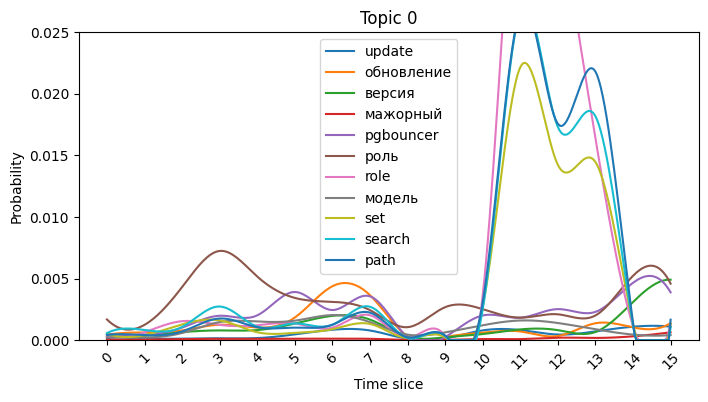

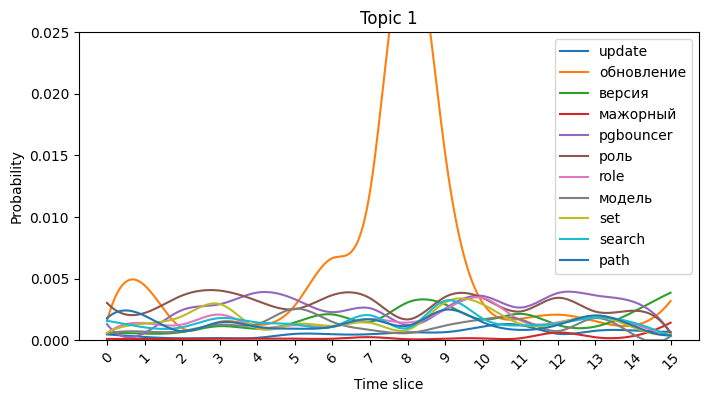

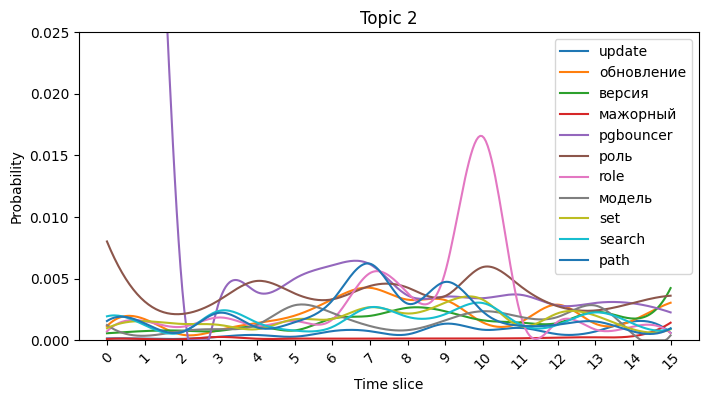

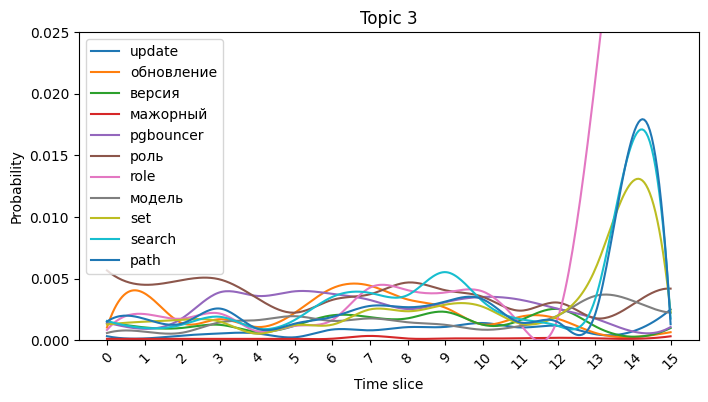

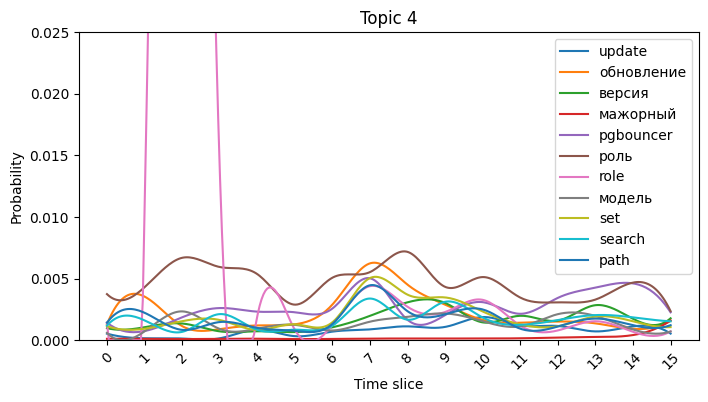

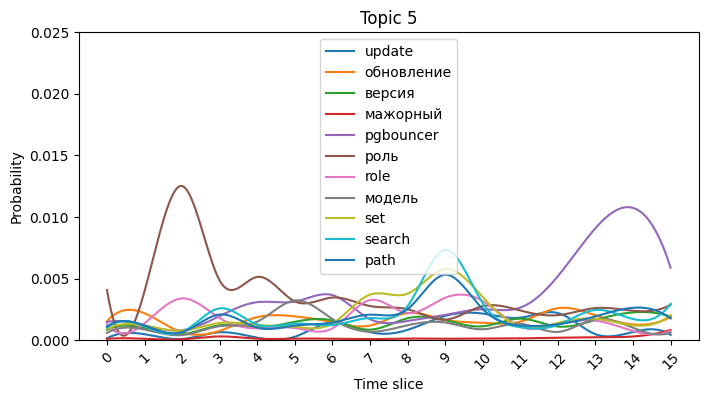

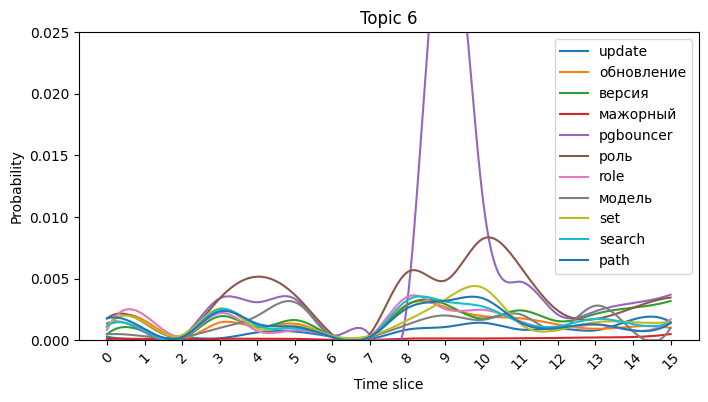

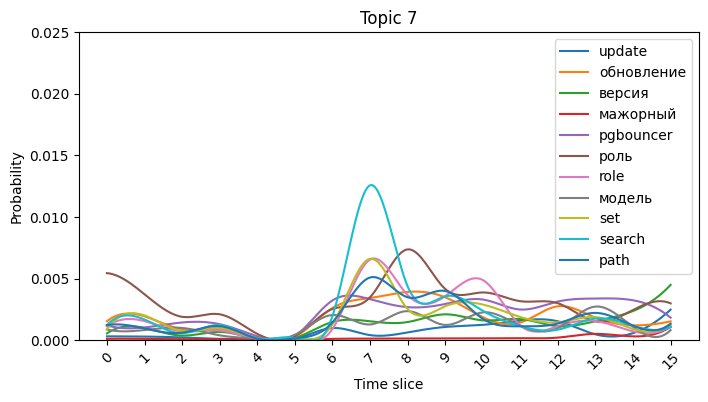

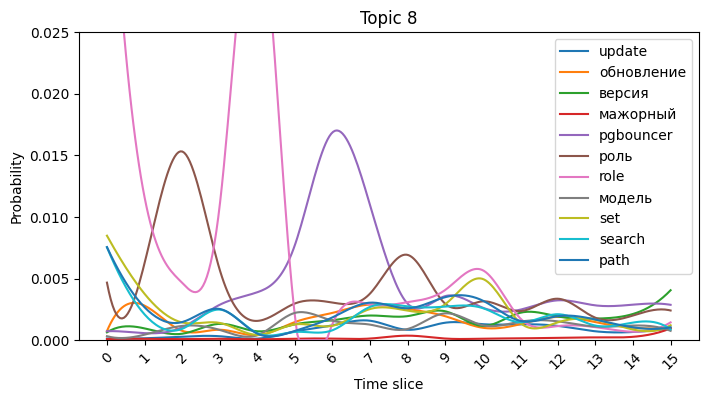

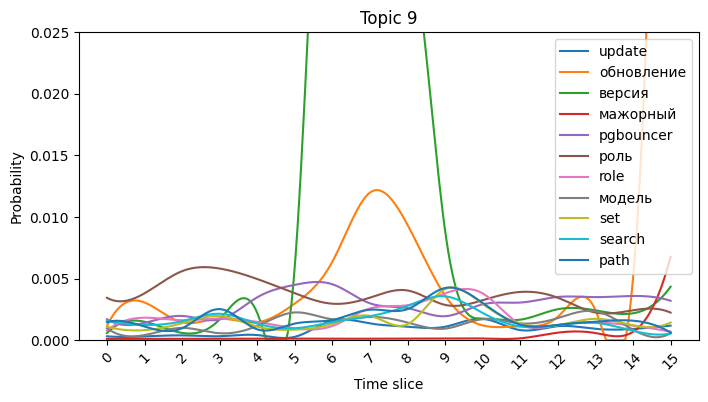

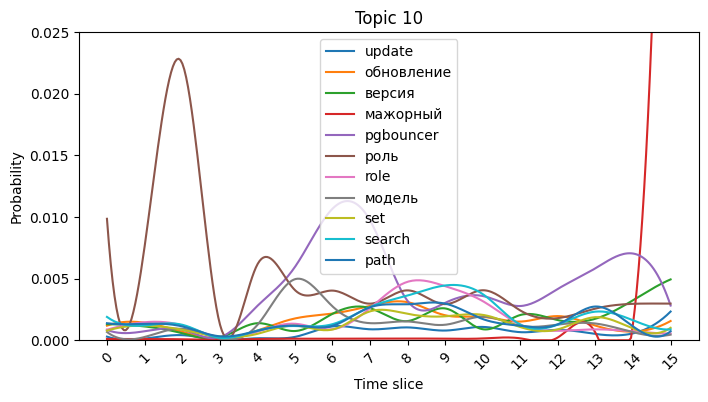

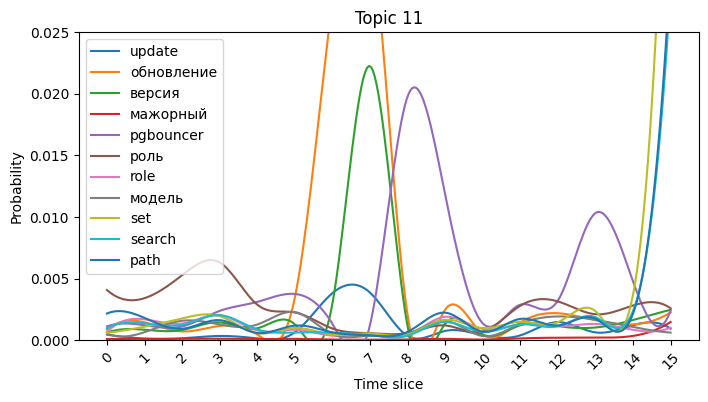

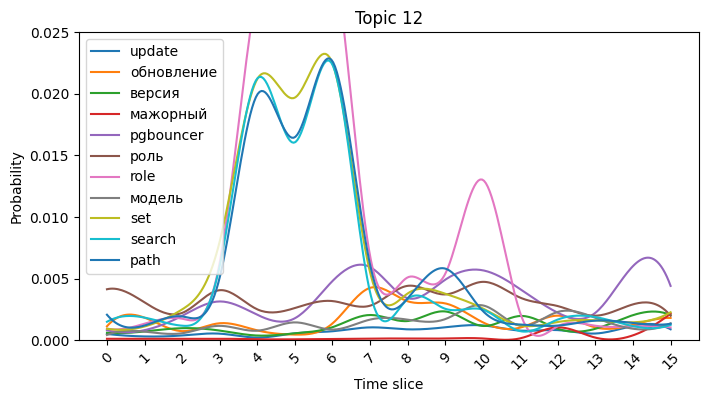

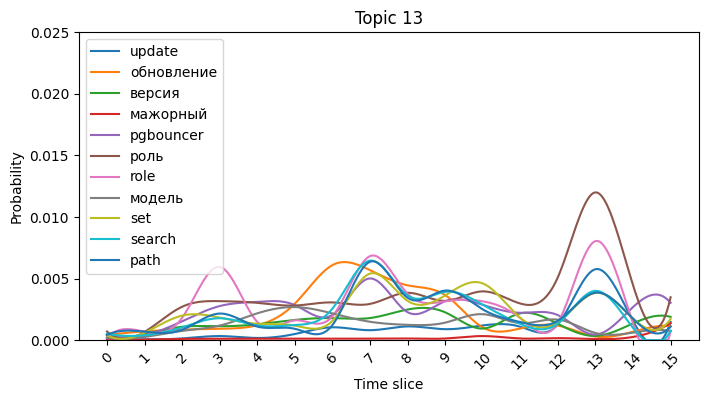

In [ ]:
# plot the evolution of word probabilities over time for each topic and word
for topic in range(num_topics):
    fig, ax = plt.subplots(figsize=(8, 4))
    for i in range(num_top_words):
        word = top_words[topic][i]
        topic_word_probs = []
        for timeslice in range(num_timepoints):
            topic_word_dist = mdl.get_topic_word_dist(topic, timeslice)
            word_index = list(mdl.used_vocabs).index(word)
            topic_word_probs.append(topic_word_dist[word_index])
        # use a spline to smooth the data
        x_smooth = np.linspace(0, num_timepoints-1, 300)
        y_smooth = make_interp_spline(range(num_timepoints), topic_word_probs)(x_smooth)
        y_smooth = np.maximum(y_smooth, 0)
        ax.plot(
            x_smooth,
            y_smooth,
            label=f"{word}"
        )

        ax.legend()
        ax.set_xlabel("Time slice")
        ax.set_ylabel("Probability")
        ax.set_title(f"Topic {topic}")
    ax.set_ylim(0,0.025)
    pos = np.arange(0,16)
    labels = np.arange(0, 16)
    ax.set_xticks(pos)
    ax.set_xticklabels(labels, rotation = 45)

plt.show()